In [1]:
import urllib.request

urls = [
    "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-CV0101EN-Coursera/images%20/images_part_5/DLguys.jpeg",
    "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-CV0101EN-Coursera/images%20/images_part_5/watts_photos2758112663727581126637_b5d4d192d4_b.jpeg",
    "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-CV0101EN-Coursera/images%20/images_part_5/istockphoto-187786732-612x612.jpeg",
    "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-CV0101EN-Coursera/images%20/images_part_5/jeff_hinton.png"
]

for url in urls:
    filename = url.split("/")[-1]  # Extract the filename from the URL
    urllib.request.urlretrieve(url, filename)
    print(f"Downloaded: {filename}")


Downloaded: DLguys.jpeg
Downloaded: watts_photos2758112663727581126637_b5d4d192d4_b.jpeg
Downloaded: istockphoto-187786732-612x612.jpeg
Downloaded: jeff_hinton.png


In [2]:
#Deep learning libraries:
import torchvision
from torchvision import transforms
import torch
from torch.autograd import no_grad

In [3]:
import requests #Getting data from web

In [4]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

 The following function will assign a string name to a predicted class and eliminates predictions whose likelihood is under a treshold.

In [5]:
def get_predictions(pred, threshold=0.7, objects=None):
    
#Pred: A list where each element contains a tuple that corresponds to information about the different objects; Each element  includes a tuple with the class yhat, probability of belonging to the class and the coordinates of the bounding box corresponding to the object.
#Image: frozen surface
#Predicted_classes: A list where each elemnt contains a tuple that corresponds to information about the different objects: Each elemnet includes a tuple with the class name, probability of belonging to that class and the coordinates of the bounding boxcorresponding to the object.
#p: Confidence.
#(box[0], box[1]) → Top-left corner (x, y)
#(box[2], box[3]) → Bottom-right corner (x, y)
    predicted_classes = [
    (COCO_INSTANCE_CATEGORY_NAMES[i], p, [(box[0], box[1]), (box[2], box[3])]) 
    for i, p, box in zip(
        pred[0]['labels'].numpy(), 
        pred[0]['scores'].detach().numpy(), 
        pred[0]['boxes'].detach().numpy())]

    predicted_classes = [stuff for stuff in predicted_classes if stuff[1]>threshold]
                          
    if objects and predicted_classes:
        predicted_classes = [(name,p,box) for name, p, box in predicted_classes if name in objects]
    return predicted_classes

Draw box arround each object

In [6]:
def draw_box(predicted_classes, image, rect_th=10, text_size=3, text_th=3):
    """
    Draws a box around each object.
    
    predicted_classes: a list where each element contains a tuple that corresponds to information about the different objects;
                       each element includes a tuple with the class name, probability of belonging to that class, and the coordinates of the bounding box corresponding to the object.
    image: frozen surface
    """
    
    # Convert image from tensor to numpy array
    img = (np.clip(cv2.cvtColor(np.clip(image.numpy().transpose((1, 2, 0)), 0, 1), cv2.COLOR_RGB2BGR) * 255, 0, 255)).astype(np.uint8).copy()

    # Loop over predicted classes and draw boxes and labels
    for predicted_class in predicted_classes:
        label = predicted_class[0]
        probability = predicted_class[1]
        box = predicted_class[2]

        # Draw rectangle around object
        cv2.rectangle(img, box[0], box[1], (0, 255, 0), rect_th)  # Draw rectangle with the coordinates

        # Put label and probability text on the image
        cv2.putText(img, label, box[0], cv2.FONT_HERSHEY_SIMPLEX, text_size, (0, 255, 0), thickness=text_th)
        cv2.putText(img, label + ": " + str(round(probability, 2)), box[0], cv2.FONT_HERSHEY_SIMPLEX, text_size, (0, 255, 0), thickness=text_th)

    # Show the image
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

    # Clean up memory
    del img
    del image


Function to free up some memory:

In [7]:
def save_RAM(image_=False):
    global image, img, pred
    torch.cuda.empty_cache()
    del(img)
    del(pred)
    if image_:
        image.close()
        del(image)

*Load Pre-trained Faster R-CNN*

Faster R-CNN is a model taht predicts both bounding boxes and class scores for potential objects in the image pre-trained on COCO.

model_=torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model_.eval()#Puts the model in evaluation mode (as opposed to training the mode)

for name, param in model_.named_parameters():
    param.requires_grad=False
print("done")

In [8]:
import torchvision
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights

# Load the model with pretrained weights
model_ = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1)

model_.eval()  # Put the model in evaluation mode


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [9]:
def model(x):
    with torch.no_grad():
        yhat = model_(x)
    return yhat

91 Classes:

In [10]:
COCO_INSTANCE_CATEGORY_NAMES = [ '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']
len(COCO_INSTANCE_CATEGORY_NAMES)

91

*Object Localization*

In object localization we locate the presence of objects in an image and indicate there location with a bounding box.

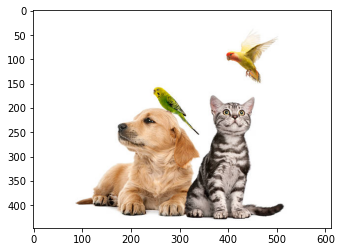

In [11]:
img_path='istockphoto-187786732-612x612.jpeg'
half=0.5
image=Image.open(img_path)

image.resize([int(half*s)for s in image.size])

plt.imshow(image)
plt.show()

In [12]:
#Transform object to convert image to tensor:
transform = transforms.Compose([transforms.ToTensor()])

In [13]:
img = transform(image)

In [14]:
#Prediction
pred = model([img])

In [15]:
pred[0]['labels']

tensor([16, 17, 18, 16, 17, 18, 15, 17, 63, 17, 18, 18, 17])

In [16]:
pred[0]['scores']

tensor([0.9976, 0.9974, 0.9929, 0.9781, 0.7116, 0.4929, 0.1863, 0.0813, 0.0793,
        0.0676, 0.0667, 0.0618, 0.0617])

In [17]:
#The class number corresponds to the index of the list with the corresponding category name.
index=pred[0]['labels'][0].item()
COCO_INSTANCE_CATEGORY_NAMES[index]

'bird'

In [18]:
#Coordinates for the bounding box
bounding_box=pred[0]['boxes'][0].tolist()
bounding_box

[396.1119079589844, 40.974849700927734, 500.2917175292969, 147.1243896484375]

In [19]:
#Box: top(t), left(l), bottom(b), right(r)
t,l,b,r=[round(x) for x in bounding_box]

Now we convert the tensor to an openCV array and plot an image with the box:


In [20]:
if isinstance(img, torch.Tensor):
    img = img.cpu().detach().numpy()  # Convert PyTorch tensor to NumPy


In [21]:
print("Shape of img before processing:", img.shape)


Shape of img before processing: (3, 447, 612)


img_plot = (np.clip(cv2.cvtColor(np.clip(img.transpose((1, 2, 0)), 0, 1), cv2.COLOR_RGB2BGR) * 255, 0, 255)).astype(np.uint8)

#img = (np.clip(cv2.cvtColor(np.clip(img.numpy().transpose((1, 2, 0)), 0, 1), cv2.COLOR_RGB2BGR) * 255, 0, 255)).astype(np.uint8)
cv2.rectangle(img_plot, (t,l), (b,r), (0,0,255),10)
print("Shape of img before processing:", img.shape)
plt.imshow(cv2.cvtColor(img_plot, cv2.COLOR_BGR2RGB))
plt.show()
del img_plt, t, l, r, b

In [22]:
print(f"t: {t}, l: {l}, b: {b}, r: {r}")


t: 396, l: 41, b: 500, r: 147


In [23]:
#cv2.rectangle(img, (l, t), (r, b), (0, 0, 255), 10)


In [24]:
if img.shape[0] in [1, 3]:  # Check if it's (C, H, W)
    img= img.transpose((1, 2, 0))  # Convert to (H, W, C)


img_plot = np.clip(img*255, 0,255).astype(np.uint8)
print("Final img_plot dtype: ", img_plot.dtype)
print("Final img_plot shape: ", img_plot.shape)
cv2.rectangle(img_plot, (l,t),(r,b), (0,0,255), 10)
plt.imshow(cv2.cvtColor(img_plot, cv2.COLOR_BGR2RGB))
plt.show()
del img_plot, t,l,b,r

Final img_plot dtype: uint8
Final img_plot shape: (447, 612, 3)


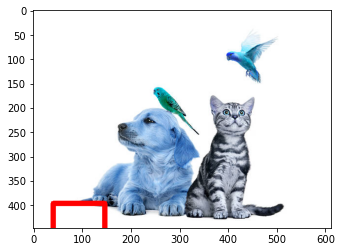

In [25]:
# Ensure that img_plot is a proper 3-channel image (H, W, 3) and of type uint8
img_plot = np.clip(img * 255, 0, 255).astype(np.uint8)

# Ensure img_plot is contiguous in memory
img_plot = img_plot.copy()

# Debugging prints
print("Final img_plot dtype:", img_plot.dtype)
print("Final img_plot shape:", img_plot.shape)

# Draw the rectangle
cv2.rectangle(img_plot, (l, t), (r, b), (0, 0, 255), 10)

# Show the image with the bounding box
plt.imshow(cv2.cvtColor(img_plot, cv2.COLOR_BGR2RGB))
plt.show()

# Clean up memory (optional)
del img_plot, t, l, b, r
